In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal

import random
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import seaborn as sns

# Use this Path if Loading the Dataset
path = os.getcwd()
electro_dir = os.path.dirname(path) 
data_dir = os.path.dirname(electro_dir) + "/data/electrosense/data/"

# Use this if testing results generated from code
data_dir = path + "/results/"
print(data_dir)

/home/ahalya/Documents/projects/mechanical-intelligence/electrosense/src/results/


In [3]:
file_path1 = data_dir + "ergodic/data_dict.pickle"
with open(file_path1, 'rb') as f: 
    data_dict1 = pickle.load(f, encoding="bytes")
obj1 = data_dict1['obj_list'][0]
traj1 = data_dict1['traj']
loss1 = data_dict1['loss']
buffer1 = data_dict1['data_buffer']
action1 = data_dict1['actions']
# Load Pickled Data
file_path3 = data_dir + "random/data_dict.pickle"
with open(file_path3, 'rb') as f: 
    data_dict3 = pickle.load(f, encoding="bytes")
obj3 = data_dict3['obj_list'][0]
traj3 = data_dict3['traj']
loss3 = data_dict3['loss']
buffer3 = data_dict3['data_buffer']
action3 = data_dict3['actions']



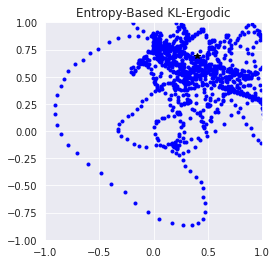

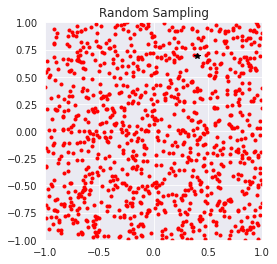

In [4]:
# Plot Trajectories

# Active Ergodic Sampling (KL-E2)
sns.set_style('darkgrid')
plt.plot(traj1[:,0], traj1[:,1], 'b.', label="Entropy")
plt.plot(obj1[0], obj1[1], 'k*')
plt.axis('square')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("Entropy-Based KL-Ergodic")
plt.show()

# Random Sampling
sns.set_style('darkgrid')
plt.plot(traj3[:,0], traj3[:,1], 'r.', label="Random")
plt.plot(obj1[0], obj1[1], 'k*')
plt.axis('square')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("Random Sampling")
plt.show()


In [6]:
# from src.vae import VAE
from electro_utils import *

measurement_model = MeasurementModel()
measurement_model_actual = MeasurementModel_nonoise()

In [7]:
# Load Pytorch Models
model1 = torch.load(data_dir + "ergodic/model_final.pth")
model1.eval()

model2 = torch.load(data_dir + "random/model_final.pth")
model2.eval()



/home/ahalya/python-envs/sensory-learning/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ahalya/python-envs/sensory-learning/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ahalya/python-envs/sensory-learning/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has change

VAE(
  (encode): Sequential(
    (0): Linear(in_features=443, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
  (decode): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=442, bias=True)
  )
)

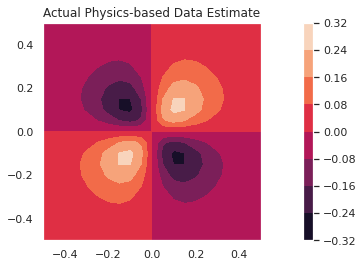

In [8]:
# Plot Actual data experienced over object of interest in env
sns.set(style='darkgrid')
xr = np.expand_dims(obj1, 0)
xr = torch.FloatTensor(xr)
yact = torch.FloatTensor(measurement_model_actual(obj1-xr.detach().numpy()))
data = yact.reshape((21,21))
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.contourf(measurement_model_actual.xx, measurement_model_actual.yy, data)
plt.colorbar()
plt.axis('square')
plt.scatter(obj1[0],obj1[1], c='k')
plt.gcf()
plt.title("Actual Physics-based Data Estimate")
plt.show()

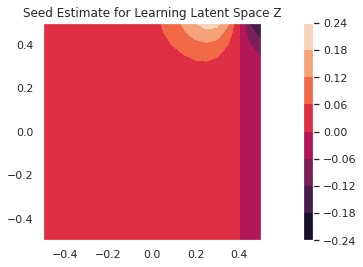

In [9]:
xr = np.expand_dims(obj1, 0)
xr = torch.FloatTensor(xr)
yact = torch.FloatTensor(measurement_model_actual(obj1-0*xr.detach().numpy()))
data = yact.reshape((21,21))
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.contourf(measurement_model_actual.xx, measurement_model_actual.yy, data)
plt.colorbar()
plt.axis('square')
plt.title('Seed Estimate for Learning Latent Space Z')
plt.gcf()
plt.show()


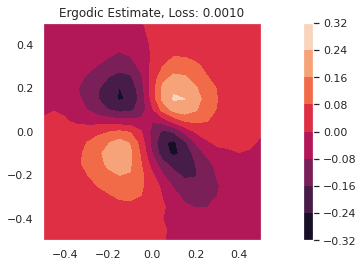

Ergodic loss: 0.0010


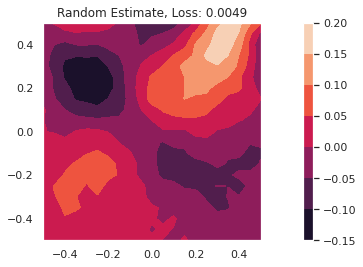

random sampling loss: 0.004923233762383461


In [14]:
loss = nn.MSELoss()

# Load Pytorch Models
model1 = torch.load(data_dir + "ergodic/model_final.pth")
model1.eval()

model3 = torch.load(data_dir + "random/model_final.pth")
model3.eval()


# Plot Entropy Final Estimate
xr = 0* np.random.uniform(-1.,1., size=(1,2))#np.array([obj1])#0* np.random.uniform(-1.,1., size=(1,2))
y = measurement_model(obj1-xr)

xr = torch.FloatTensor(xr)
y = torch.FloatTensor(y)

y_pred, y_logvar, z_mu, z_logvar, z_samples = model1(xr, y)

xr = np.expand_dims(obj1, 0)
xr = torch.FloatTensor(xr)

y_out = model1.decode(torch.cat([z_samples, xr], dim=1))
y_pred, y_logvar = y_out[:, 1:], y_out[:, 0]
data = y_pred.detach().numpy()
yact = torch.FloatTensor(measurement_model_actual(obj1-xr.detach().numpy()))
lossval = loss(y_pred, yact).item()

data = np.reshape(data, (21,21))
fig = plt.figure()

fig.patch.set_facecolor('white')
plt.contourf(measurement_model.xx, measurement_model.yy, data)
plt.colorbar()
plt.axis('square')
plt.scatter(obj1[0],obj1[1], c='k')
plt.title('Ergodic Estimate, Loss: {:.4f}'.format(lossval))
plt.gcf()
plt.show()

print("Ergodic loss: {:.4f}".format(lossval))

# Plot Random Sampling Estimate

y_pred, y_logvar, z_mu, z_logvar, z_samples = model3(xr, y)

xr = np.expand_dims(obj1, 0)
xr = torch.FloatTensor(xr)

y_out = model3.decode(torch.cat([z_samples, xr], dim=1))
y_pred, y_logvar = y_out[:, 1:], y_out[:, 0]
data = y_pred.detach().numpy()
yact = torch.FloatTensor(measurement_model_actual(obj1-xr.detach().numpy()))
lossval = loss(y_pred, yact).item()

data = np.reshape(data, (21,21))
fig = plt.figure()

fig.patch.set_facecolor('white')
plt.contourf(measurement_model.xx, measurement_model.yy, data)
plt.colorbar()
plt.axis('square')
plt.scatter(obj1[0],obj1[1], c='k')
plt.title('Random Estimate, Loss: {:.4f}'.format(lossval))
plt.gcf()
plt.show()

print("random sampling loss: {}".format(lossval))

j: 926


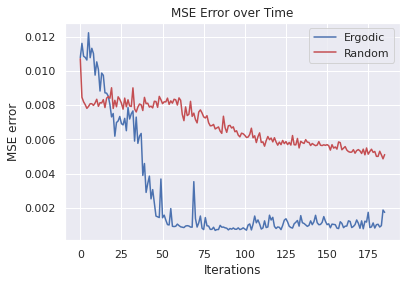

In [13]:
xdef = 0* np.random.uniform(-1.,1., size=(1,2))#np.array([obj1])
ydef = measurement_model(obj1-xdef)

xd = torch.FloatTensor(xdef)
yd = torch.FloatTensor(ydef)

# Entropy MSE over time
mseloss1 = []
for j in range(1,931,5): 
    clear_output(wait=True)
    print("j: {}".format(j))
    PATH =  data_dir + "ergodic/model_checkpoint_iter"+str(j)+".pth"
    model1.load_state_dict(torch.load(PATH)['state_dict'])
    model1.eval()

    y_pred, y_logvar, z_mu, z_logvar, z_samples = model1(xd, yd)
    xr = np.expand_dims(obj1, 0)
    xr = torch.FloatTensor(xr)
    y_out = model1.decode(torch.cat([z_samples, xr], dim=1))
    y_pred, y_logvar = y_out[:, 1:], y_out[:, 0]
    data = y_pred.detach().numpy()
    yact = torch.FloatTensor(measurement_model(obj1-xr.detach().numpy()))
    lossval = loss(y_pred, yact).item()

    mseloss1.append(lossval)

# Random Sampling
mseloss3 = []
for j in range(1,931,5): 
    clear_output(wait=True)
    print("j: {}".format(j))
    PATH =  data_dir + "random/model_checkpoint_iter"+str(j)+".pth"
    model3.load_state_dict(torch.load(PATH)['state_dict'])
    model3.eval()

    y_pred, y_logvar, z_mu, z_logvar, z_samples = model3(xd, yd)

    xr = np.expand_dims(obj1, 0)
    xr = torch.FloatTensor(xr)
    y_out = model3.decode(torch.cat([z_samples, xr], dim=1))
    y_pred, y_logvar = y_out[:, 1:], y_out[:, 0]
    data = y_pred.detach().numpy()
    yact = torch.FloatTensor(measurement_model(obj1-xr.detach().numpy()))
    lossval = loss(y_pred, yact).item()
    mseloss3.append(lossval)
    
plt.plot(mseloss1, 'b', label='Ergodic')
plt.plot(mseloss3, 'r', label='Random')
plt.xlabel('Iterations')
plt.ylabel('MSE error')
plt.title('MSE Error over Time')
plt.legend()
plt.gcf()
plt.show()